In [1]:
%reload_ext autoreload
from env import SingleStateSpace 
from generate_trajectory import generate_trajectory
from policy import Boltzmann 
from learn import compute_q_with_values
from RewardFunctions import SingleStateReward
import numpy as np 
from learn import policy_iteration
from utils import normalise_pi
from policy_walk import policy_walk 
import matplotlib.pyplot as plt 

In [2]:
#Set up the environment
trajectory_length = 20 
env = SingleStateSpace(n_actions = 10, discount_rate = 0.1, R_max = 5)

#generate observation times 
observation_times = np.cumsum(np.random.uniform(0, 2, size=trajectory_length))
print("Generated observation times:") 
print(observation_times)

#Create a matrix for the true rewards 
s_grid, a_grid, t_grid = np.meshgrid(env.states, env.actions, observation_times, indexing='ij')
R = np.vectorize(env.reward)(s_grid,a_grid,t_grid)

#Find the optimal policy, values and q_values for the true reward to generate the trajectory. 
(optimal_pi, optimal_values, optimal_q_values) = policy_iteration(env, len(observation_times), R)
b = Boltzmann(optimal_q_values, env.actions, alpha = 100)
observations = generate_trajectory(env,b,observation_times)

print("Generated trajectory") 
print(observations)

#Sample from policy walk - I discard the first half of each policy walk iteration.
learned_rewards = policy_walk(env,observations,n_iters=10000)[5000:10000]
policy_walk_iters = 10
for _ in range(policy_walk_iters-1): 
    learned_rewards = np.concatenate((learned_rewards, policy_walk(env,observations,n_iters=10000)[5000:10000]))

Generated observation times:
[ 1.8161564   3.04739731  4.95804392  6.38056234  6.92238273  7.42579471
  8.48234454 10.40018408 11.10668016 12.2610496  14.24708045 14.37606999
 14.45112546 16.12801903 16.70061977 18.41496622 18.75161431 19.12368929
 19.54252836 20.04878415]
Generated trajectory
[[0, 2, 0], [0, 3, 1], [0, 5, 2], [0, 6, 3], [0, 7, 4], [0, 7, 5], [0, 8, 6], [0, 9, 7], [0, 9, 8], [0, 8, 9], [0, 6, 10], [0, 6, 11], [0, 6, 12], [0, 4, 13], [0, 3, 14], [0, 2, 15], [0, 1, 16], [0, 1, 17], [0, 0, 18], [0, 0, 19]]


[ 1.8161564   3.04739731  4.95804392  6.38056234  6.92238273  7.42579471
  8.48234454 10.40018408 11.10668016 12.2610496  14.24708045 14.37606999
 14.45112546 16.12801903 16.70061977 18.41496622 18.75161431 19.12368929
 19.54252836 20.04878415]


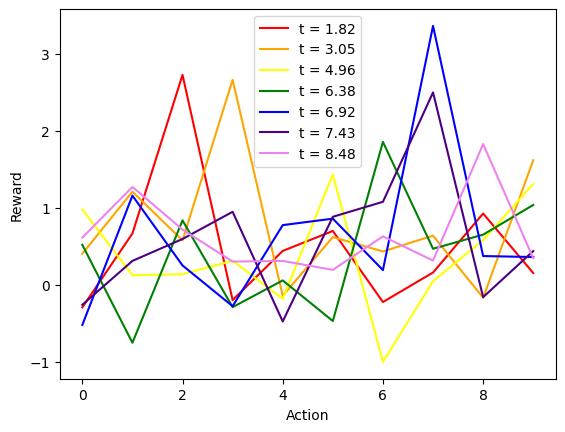

In [3]:
avg_reward = np.average(np.asarray(learned_rewards),axis = 0)
print(observation_times)
colors = ["red", "orange","yellow","green","blue","indigo","violet"]
for t in range(7):
    label = "t = " + format(round(observation_times[t],2))
    plt.plot(avg_reward[0,:,t], color=colors[t], label = label)
plt.ylabel("Reward")
plt.xlabel("Action")
plt.legend()
plt.show()

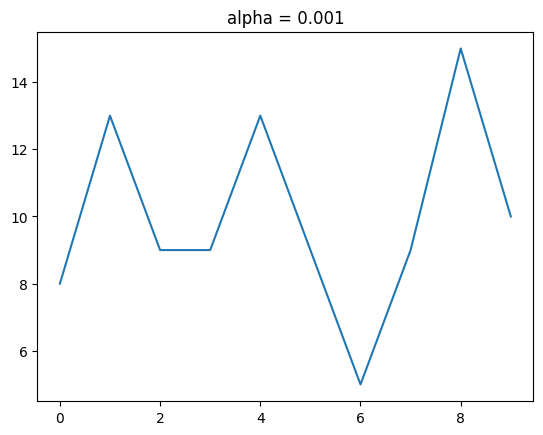

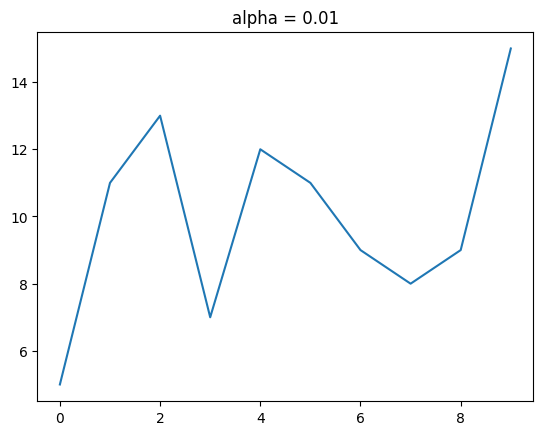

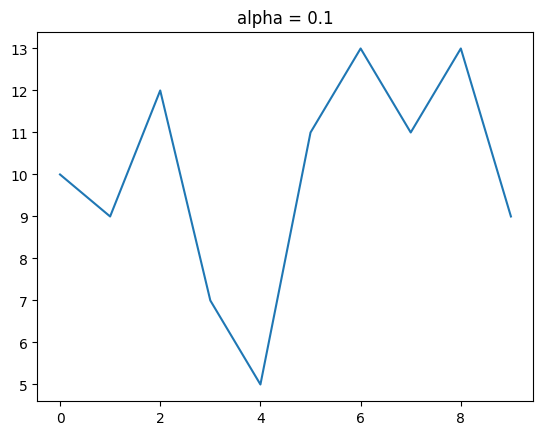

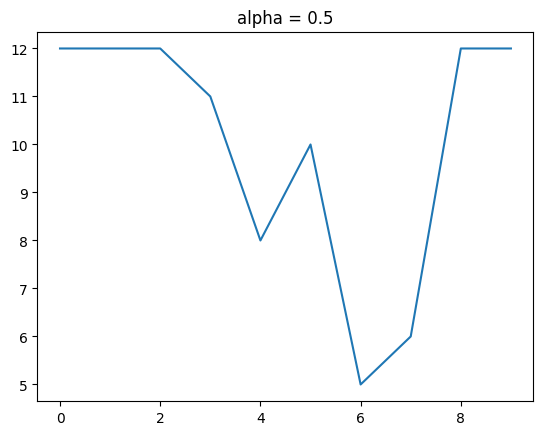

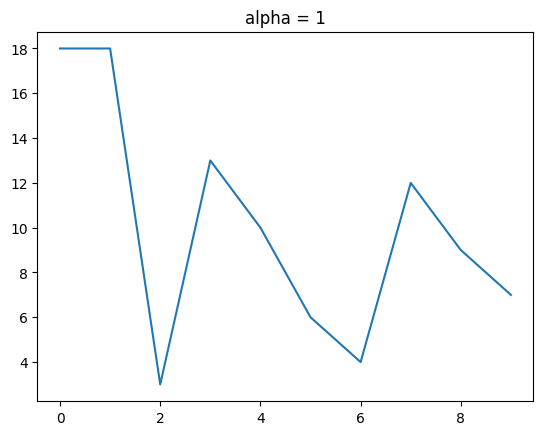

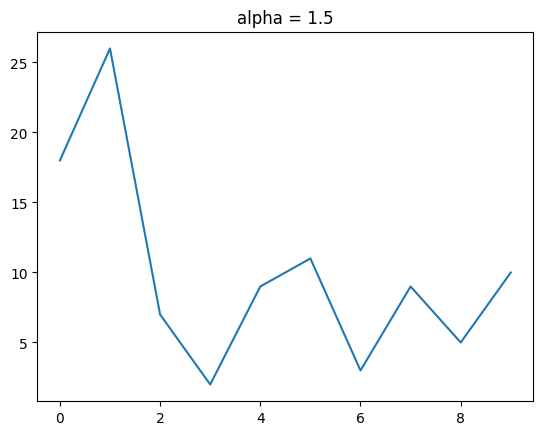

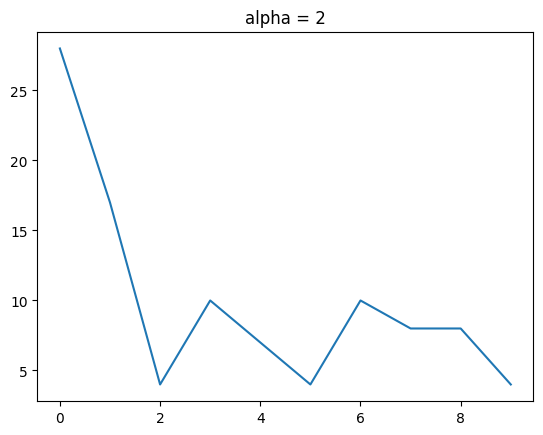

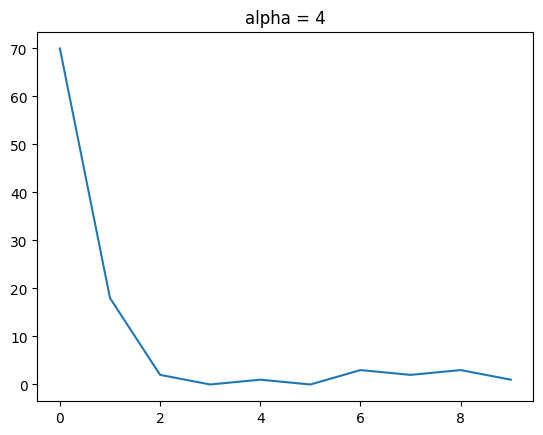

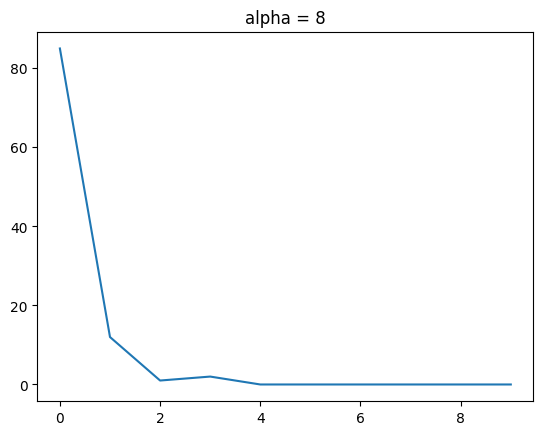

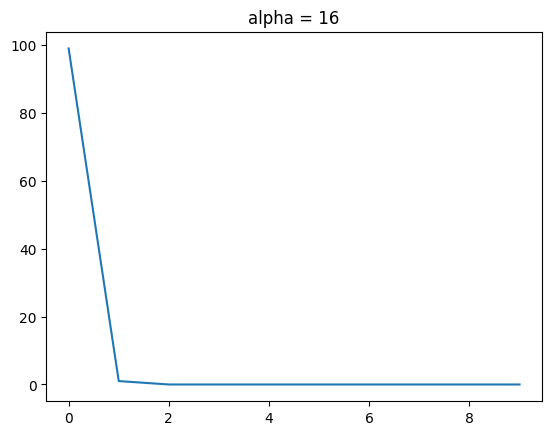

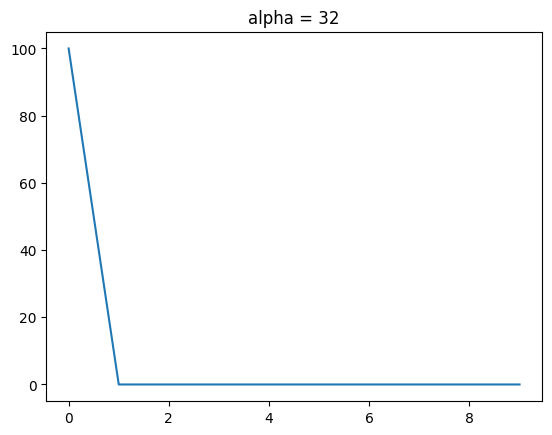

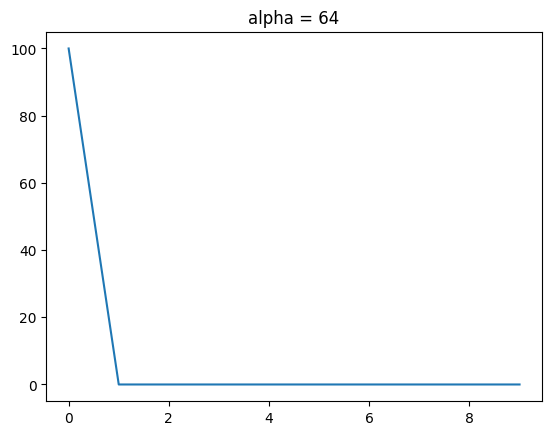

In [26]:
#Seeing how different alpha values effects the boltzmann agent. 

b = Boltzmann(optimal_q_values, env.actions)
alphas = [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2, 4, 8, 16, 32, 64]
for alpha in alphas: 
    b = Boltzmann(optimal_q_values,env.actions,alpha) 
    
    count = np.zeros(env.n_actions)
    for i in range(100): 
        count[b(0,0)] += 1
    plt.plot(count) 
    asd = "alpha = " + format(alpha)
    plt.title(asd)
    plt.show()